# Customer Segmentation using RFM Analysis & Clustering using K-Means

A simple yet powerful marketing technique is an analysis utilizing recency (how recent was the customer's last purchase), frequency (how often did the customer make a purchase in a given period) and monetary (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns.

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

Data: ../data/transactions.csv

Hints: For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Data Preparation/Data Cleaning

In [3]:
df = pd.read_csv('transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [4]:
df.shape

(125000, 3)

In [5]:
df.isnull().sum().sort_values(ascending=False)

customer_id     0
trans_date      0
trans_amount    0
dtype: int64

In [6]:
df.duplicated().sum()

6

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### 2. Exploratory Data Analysis

*There are invalid dates in the data (e.g. 2017-02-29) so we need to change them*

In [8]:
df['trans_date'] = pd.to_datetime(df['trans_date'], errors='coerce')
df['trans_date'] = df['trans_date'].replace(np.nan, '2017-02-28')

In [9]:
df['trans_date'] = df['trans_date'].astype('datetime64[ns]')
df.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

In [10]:
df.describe()

,trans_amount
count,124994.000000
mean,64.992504
std,22.859952
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


### 3. RFM Analysis

Recency-Frequency-Monetary

RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.

- Recency — how long it’s been since a customer bought something from us
- Frequency — how often a customer buys from us
- Monetary value — the total value of purchases a customer has made

#### 3.a. Recency

In [11]:
now = dt.datetime(2021,8,28)

In [12]:
df_recency = df.groupby(['customer_id'],as_index=False)['trans_date'].max()
df_recency.columns = ['customer_id','Last_Purchase_Date']
df_recency['Recency'] = now - df_recency['Last_Purchase_Date']
df_recency['Recency'] = df_recency['Recency'].astype('timedelta64[D]')
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,customer_id,Recency
0,CS1112,592.0
1,CS1113,566.0
2,CS1114,563.0
3,CS1115,541.0
4,CS1116,734.0


#### 3.b. Frequency

In [13]:
df_frequency = df.groupby(['customer_id'],as_index=False)['trans_date'].count()
df_frequency.columns = ['customer_id','Frequency']
df_frequency.head()

,customer_id,Frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13


#### 3.c. Monetary

In [14]:
df_monetary = df.groupby(['customer_id'],as_index=False)['trans_amount'].sum()
df_monetary.columns = ['customer_id','Monetary']
df_monetary.head()

,customer_id,Monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857


#### 3.d. RFM Table

In [15]:
RFM_Table = df_recency.merge(df_frequency,on='customer_id').merge(df_monetary,on='customer_id')
RFM_Table.head()

,customer_id,Recency,Frequency,Monetary
0,CS1112,592.0,15,1012
1,CS1113,566.0,20,1490
2,CS1114,563.0,19,1432
3,CS1115,541.0,22,1659
4,CS1116,734.0,13,857


In [16]:
RFM_Table.describe()

,Recency,Frequency,Monetary
count,6889.000000,6889.000000,6889.000000
mean,611.349252,18.143998,1179.223835
std,85.545443,5.193150,465.833636
min,530.000000,4.000000,149.000000
25%,553.000000,14.000000,781.000000
50%,584.000000,18.000000,1227.000000
75%,642.000000,22.000000,1520.000000
max,1388.000000,39.000000,2933.000000


#### 3.e. RFM Segment

Now we split the metrics into segments using quantiles. We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [17]:
R_labels =range(4,0,-1)
F_labels=range(1,5)
M_labels=range(1,5)
R_quartile = pd.qcut(RFM_Table['Recency'], q=4, labels = R_labels)
F_quartile = pd.qcut(RFM_Table['Frequency'],q=4, labels = F_labels)
M_quartile = pd.qcut(RFM_Table['Monetary'],q=4, labels = M_labels)
RFM_Table = RFM_Table.assign(R=R_quartile,F=F_quartile,M=M_quartile)
RFM_Table.head()

,customer_id,Recency,Frequency,Monetary,R,F,M
0,CS1112,592.0,15,1012,2,2,2
1,CS1113,566.0,20,1490,3,3,3
2,CS1114,563.0,19,1432,3,3,3
3,CS1115,541.0,22,1659,4,3,4
4,CS1116,734.0,13,857,1,1,2


**Calculating the total RFM score combined**

RFM_Score = R_quartile + F_quartile + M_quartile

In [18]:
def rfm_segment(x) : return str(x['R']) + str(x['F']) + str(x['M'])
RFM_Table['RFM_Segment'] = RFM_Table.apply(rfm_segment,axis=1)
RFM_Table['RFM_Score'] = RFM_Table[['R','F','M']].sum(axis=1)
RFM_Table.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,CS1112,592.0,15,1012,2,2,2,222,6
1,CS1113,566.0,20,1490,3,3,3,333,9
2,CS1114,563.0,19,1432,3,3,3,333,9
3,CS1115,541.0,22,1659,4,3,4,434,11
4,CS1116,734.0,13,857,1,1,2,112,4


In [19]:
RFM_Table['RFM_Score'].unique()

array([ 6,  9, 11,  4,  5,  8, 12,  7, 10,  3], dtype=int64)

In [20]:
RFM_Table.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           766.1      10.7    501.3   550
4           661.4      12.7    649.3   548
5           639.2      14.1    818.9   737
6           599.6      15.0    892.5   824
7           611.1      17.5   1136.0   851
8           586.9      18.7   1264.0   844
9           595.0      21.2   1466.7   755
10          572.5      22.7   1595.8   806
11          559.7      24.5   1735.1   536
12          540.2      25.8   1817.6   438

In [21]:
def segmentation(df):
    if df['RFM_Score'] > 9 :
        return 'High Value'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Mid Value'
    else:  
        return 'Low Value'

RFM_Table['Segment'] = RFM_Table.apply(segmentation,axis=1)
RFM_Table.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
0,CS1112,592.0,15,1012,2,2,2,222,6,Mid Value
1,CS1113,566.0,20,1490,3,3,3,333,9,Mid Value
2,CS1114,563.0,19,1432,3,3,3,333,9,Mid Value
3,CS1115,541.0,22,1659,4,3,4,434,11,High Value
4,CS1116,734.0,13,857,1,1,2,112,4,Low Value


In [22]:
RFM_Table.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
              mean      mean     mean count
Segment                                    
High Value   560.7      24.0   1692.3  1780
Low Value    683.9      12.7    673.1  1835
Mid Value    598.2      18.0   1184.0  3274

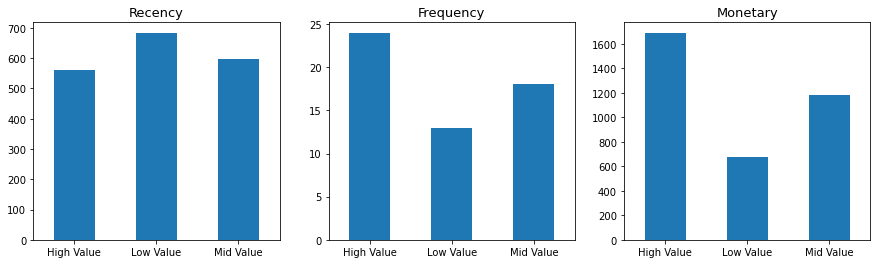

In [23]:
column = ['Recency','Frequency','Monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    RFM_Table.groupby('Segment')[j].mean().round(0).plot(kind='bar')
    plt.title('{}'.format(j), size=13)
    plt.xlabel('')
    plt.xticks(rotation=0)
plt.show()

Using RFM segmentation we can see that High Value customer has high frequency and monetary but low recency. Conversely, the Low Value customer has low frequency and monetary and also high recency.

### 4. K-Means to perform RFM (Recency, Frequency, and Monetary) customer segmentation

K-means gives the best result under the following conditions:

- Data’s distribution is not skewed (i.e. long-tail distribution)
- Data is standardised (i.e. mean of 0 and standard deviation of 1)

In [24]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s Skew: {}".format(column, skew))
    return

Recency's Skew: 2.30261333291588
Frequency's Skew: 0.10010195883473212
Monetary's Skew: -0.05259394233446752


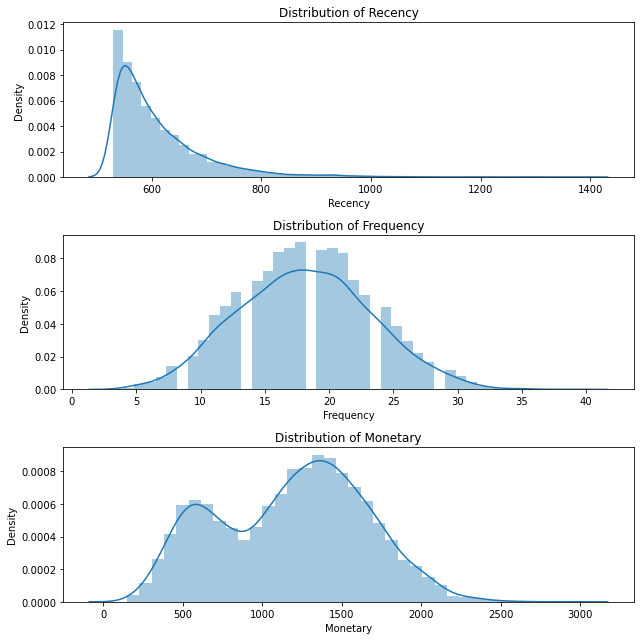

In [25]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

In [26]:
df_rfm_log = RFM_Table[['Recency','Frequency','Monetary']]

In [27]:
df_rfm_log.head()

,Recency,Frequency,Monetary
0,592.0,15,1012
1,566.0,20,1490
2,563.0,19,1432
3,541.0,22,1659
4,734.0,13,857


We will perform log transformations to reduce the skewness.

Recency's Skew: 1.6286698841523684
Frequency's Skew: 0.10010195883473212
Monetary's Skew: -0.8977383667688065


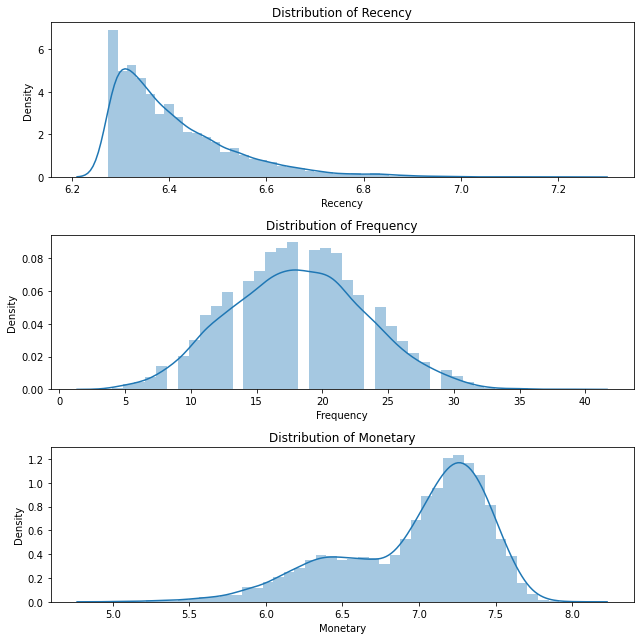

In [28]:
df_rfm_log['Recency'] = np.log(df_rfm_log['Recency']+1)
df_rfm_log['Monetary'] = np.log(df_rfm_log['Monetary']+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [29]:
df_rfm_log.describe()

,Recency,Frequency,Monetary
count,6889.000000,6889.000000,6889.000000
mean,6.408944,18.143998,6.975320
std,0.124854,5.193150,0.476509
min,6.274762,4.000000,5.010635
25%,6.317165,14.000000,6.661855
50%,6.371612,18.000000,7.113142
75%,6.466145,22.000000,7.327123
max,7.236339,39.000000,7.984122


Once the skewness is reduced, we can standardised the data by centring and scaling. All the variables now have a mean of 0 and a standard deviation of 1.

In [30]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

print('mean: ', RFM_Table_scaled.mean(axis=0).round())
print('std: ', RFM_Table_scaled.std(axis=0))

mean:  [-0. -0. -0.]
std:  [1. 1. 1.]


In [31]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,-0.190229,-0.605456,-0.114694
1,-0.549355,0.357420,0.696536
2,-0.591848,0.164845,0.613265
3,-0.910549,0.742571,0.921880
4,1.529312,-0.990607,-0.463228


In [32]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

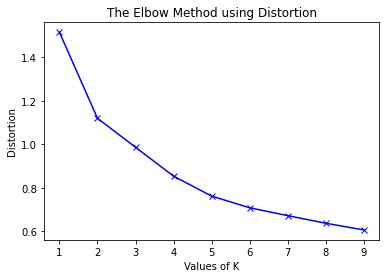

In [33]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

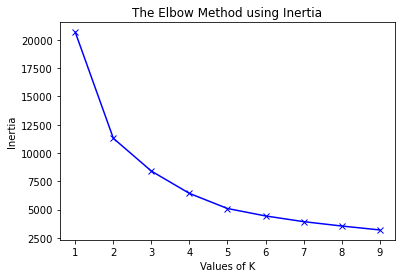

In [34]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

The cluster value where the decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose 4 or 5.

In [35]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

In [36]:
df_rfm = RFM_Table[['Recency','Frequency','Monetary']]

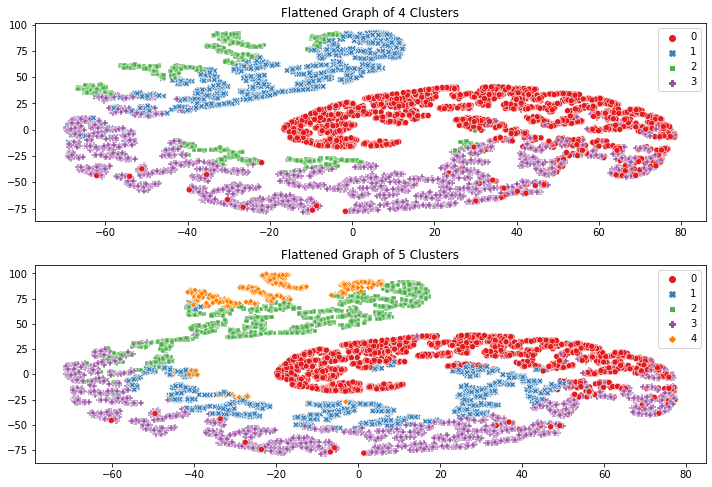

In [37]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, df_rfm)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, df_rfm)

plt.tight_layout()

In [38]:
df_rfm_k4.head()

,Recency,Frequency,Monetary,Cluster
0,592.0,15,1012,3
1,566.0,20,1490,3
2,563.0,19,1432,3
3,541.0,22,1659,0
4,734.0,13,857,2


In [39]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['customer_id', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

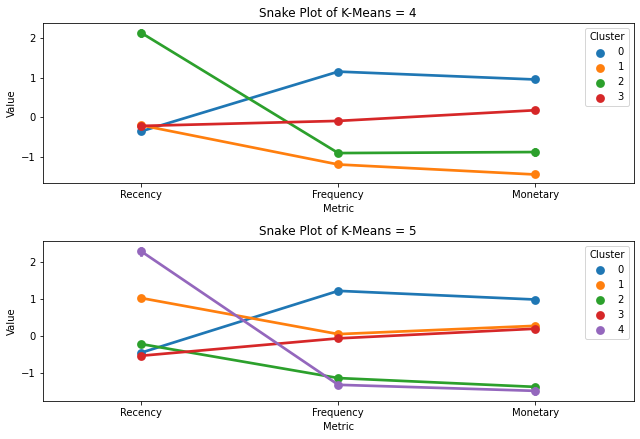

In [40]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

From the flattened graphs and the snake plots it is evident that having a cluster value of 4, segments our customers well.

**Interpretation of the clusters formed using K-Means**

In [41]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [42]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         582.0      24.0   1696.0  2125
1         593.0      12.0    562.0  1303
2         796.0      14.0    775.0   743
3         592.0      18.0   1182.0  2718

- Cluster 0: The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently, frequent buyers, and spent the most.
- Cluster 1: The second cluster can is a "Low Value" Customer. They don't order frequently and generates very low monetary.
- Cluster 2: Customers in the second cluster can be interpreted as passerby customers as their last purchase is quite long ago, purchased few and spent little. Company has to come up with new strategies to make them become regular customer.
- Cluster 3: The last cluster are Regular Customers they order regularly.

**Reference:**
https://medium.com/web-mining-is688-spring-2021/using-k-means-to-segment-customers-based-on-rfm-variables-9d4d683688c8